In [1]:
from helpers import *
from structure import UmbrellaGrid

In [2]:
degree = 3
rows = 11
cols = 11
#---
file_name = f'{degree:0>2}_{rows:0>2}_{cols:0>2}_border_center'
grid = UmbrellaGrid(degree, rows, cols)

In [3]:
border_cells = grid.border_cells()
center_cells = grid.center_cells()
active_cells    = border_cells+center_cells
target_percents = [0]*len(border_cells) + [100]*len(center_cells) # 0:undeployed | 100:deployed
#---
# active_cells    = [0, 7]
# target_percents = [0, 100]

In [4]:
grid.generate_mesh(file_name)

PLATE CHARACTERISTIQUES:
	plate thickness   : 0.006685
	plate edge length : 0.066853


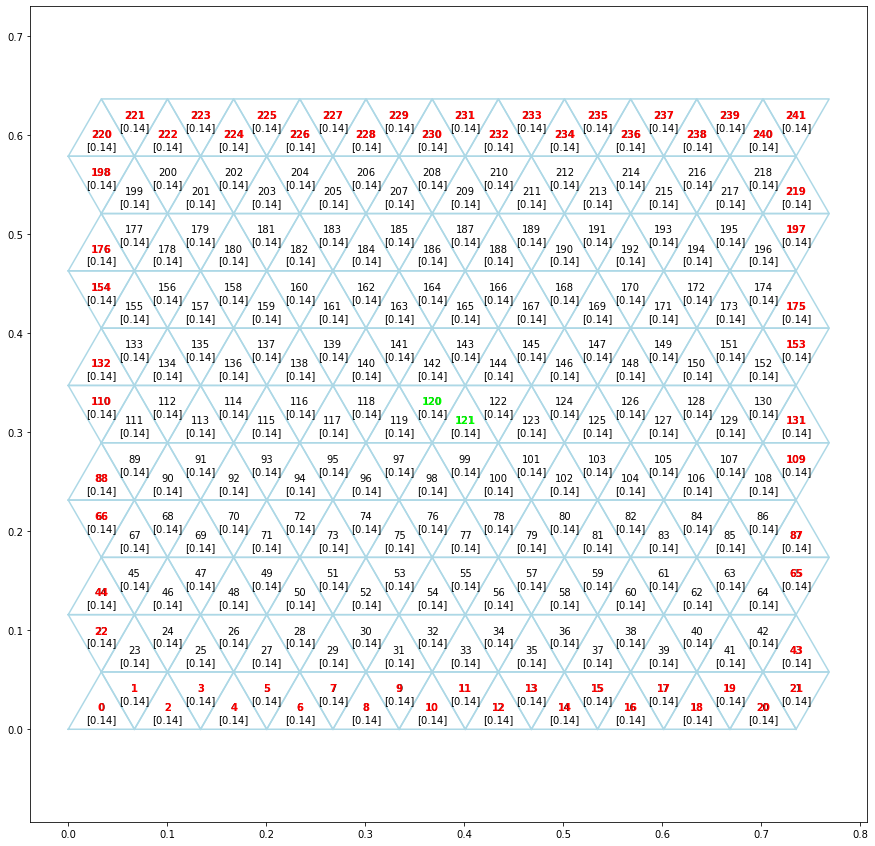

In [5]:
plot2D(grid.input_data, grid.curr_um, True, active_cells=active_cells, target_percents=target_percents)

In [6]:
view3D = plot3D(grid.curr_um, grid.input_data)
view3D.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

In [7]:
grid.deploy(active_cells, target_percents, view3D)

success: True 

energies:
  -63.999933: Full
    0.000067: Elastic
  -64.000000: Deployment
    0.000000: Repulsion
    0.000000: Attraction
    0.000000: AngleBoundPenalty



In [8]:
# if grid.rows==1 or grid.cols==1:
# projection2D(grid.input_data, grid.curr_um, active_cells=active_cells, target_percents=target_percents)

In [9]:
sview_vm = plot3D_stress(grid.curr_um, 'maxBending')
sview_vm.show()

maxBending Stresses Extrem values:
    max : 6.96e+01
    min : 0.00e+00


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

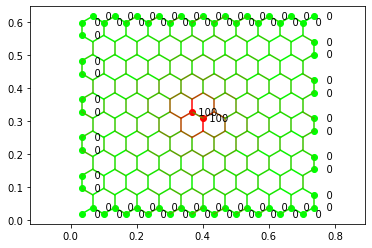

In [10]:
plot2D_stress(grid.curr_um, grid.input_data, grid.init_center_pos, active_cells, target_percents, show_percent=True)

In [11]:
deploy_in_steps(grid.curr_um,
                grid.input_data,
                grid.init_heights,
                grid.init_center_pos,
                grid.plate_thickness,
                active_cells,
                target_percents,
                steps=10,
                show_percent=False,
                stress_type='maxBending',
                dir_name=file_name,
                show_plot=False,
                verbose = True)

In [12]:
path_name = f'./images/{file_name}'
img_name = f'"{path_name}/'+'*{}*.jpg"'
gif_name = f'"{path_name}/'+'{}.gif"'
for name in ['structure', 'sPlot']:
    img_name_i = img_name.format(name)
    gif_name_i = gif_name.format(name)
    !ffmpeg  -loglevel panic -f image2 -r 3 -pattern_type glob -i $img_name_i $gif_name_i

In [13]:
# (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp)